<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

13.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 161197304 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 5499459 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [3]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [4]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0
4,1,L,F,34.0,94.537513,0.458854,63.0,8.1,7.7,25562.50000,25000.00000,9,28437687000,4781898000,12633222000,53.420228,-2.966120,33000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,L,T,12.0,72.452903,1.542007,39.0,8.5,7.5,37625.00000,40499.37500,14,27236922000,1773271000,12075555000,53.502594,-2.516861,79000.0
1135505,48,F,S,1.0,0.000000,0.000000,0.0,0.0,0.0,40000.00000,50500.00000,16,21104985000,21110074000,12654123000,51.674615,-3.212091,53000.0
1135506,55,F,T,1.0,0.000000,0.000000,0.0,0.0,0.0,41333.33333,45416.66667,14,27804846000,6355589000,11793603000,53.245090,-3.123599,70000.0
1135507,81,L,T,1.0,88.443148,2.462274,25.0,9.7,7.7,54000.00000,56650.00000,16,28051597900,2906478000,14022715000,53.734079,-2.140287,95000.0


In [5]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.33330,119166.66670,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.00000,80000.00000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.00000,279821.42860,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.00000,42908.33333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,F,D,12.0,84.705333,0.424683,42.0,7.8,6.7,48583.33333,57500.00000,26,25966523900,3773829000,12954650000,53.642111,-1.748224,415000.0
38383,11,F,D,45.0,90.592648,0.935044,53.0,10.7,8.1,70250.00000,79583.33333,26,15885462000,11716322000,410900900,52.445938,-1.924921,900000.0
38384,12,F,D,1.0,14.057832,4.594217,10.0,10.6,10.5,98833.33333,92500.00000,26,11001257000,15043775000,5857544000,52.327517,-1.079233,840000.0
38385,13,F,D,42.0,86.608374,0.258647,51.0,9.7,8.2,40875.00000,59333.33333,26,16388710900,11226349000,417089900,52.486194,-1.966257,660000.0


In [6]:
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1500000) ]
df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1500000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]

In [7]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [8]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [9]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [10]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [11]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
324237,2,2,2,22.0,95.620482,0.662041,44.0,9.0,8.1,60666.66667,58541.66667,17,26617672000,649835000,11810740000,53.510998,-2.335681,115000.0
999051,4,2,2,11.0,120.598978,0.824256,34.0,9.4,7.8,86666.66667,85166.66667,20,10248918000,31006266000,19680783000,50.787829,-1.073867,210000.0
842340,3,2,3,3.0,11.173280,4.896066,26.0,8.1,7.4,70750.00000,85000.00000,4,30404233000,5684641000,16772078000,53.984655,-2.101846,320000.0
1031782,4,2,4,20.0,93.646329,1.862523,40.0,13.8,9.9,56333.33333,53875.00000,14,13700372000,12706698000,2788044000,52.431295,-1.501946,287500.0
707499,3,1,3,10.0,70.849098,1.212115,18.0,10.4,9.1,62500.00000,48750.00000,7,27048400000,1413931000,11989725000,53.506005,-2.460859,183000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891372,4,2,4,7.0,55.384420,1.807071,19.0,12.8,10.0,60625.00000,55333.33333,15,27146737000,2133855000,11841797000,53.467095,-2.572812,305000.0
472512,3,2,2,12.0,100.476069,1.426932,36.0,8.3,7.6,81166.66667,86208.33333,7,10180357000,31032842000,19711328000,50.787964,-1.058103,215000.0
988607,4,2,4,13.0,53.303603,0.682518,32.0,8.8,8.1,58541.66667,62500.00000,5,26128271900,4343019000,13372859000,53.675990,-1.681128,310000.0
247749,2,2,3,16.0,75.452731,1.911522,43.0,9.1,8.5,80500.00000,63000.00000,11,13715910000,12858631000,2538646000,52.404068,-1.552582,140500.0


In [12]:
dataset = df_train_test_data.values
dataset

array([[2, '2', '2', ..., 53.510998, -2.335681, 115000.0],
       [4, '2', '2', ..., 50.787828999999995, -1.073867, 210000.0],
       [3, '2', '3', ..., 53.984655000000004, -2.101846, 320000.0],
       ...,
       [4, '2', '4', ..., 53.675990000000006, -1.681128, 310000.0],
       [2, '2', '3', ..., 52.404068, -1.552582, 140500.0],
       [3, '2', '3', ..., 52.89236, -1.418334, 210000.0]], dtype=object)

In [13]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [14]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [15]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [16]:
from sklearn import preprocessing

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()

In [18]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.25      , 1.        , 0.33333333, ..., 0.31309042, 0.60772638,
        0.45142497],
       [0.75      , 1.        , 0.33333333, ..., 0.52291925, 0.13832981,
        0.62057045],
       [0.5       , 1.        , 0.66666667, ..., 0.44536819, 0.68937132,
        0.48277042],
       ...,
       [0.75      , 1.        , 1.        , ..., 0.35473919, 0.63616629,
        0.53916744],
       [0.25      , 1.        , 0.66666667, ..., 0.06588051, 0.41692326,
        0.55639896],
       [0.5       , 1.        , 0.66666667, ..., 0.14832074, 0.50109085,
        0.57439484]])

In [19]:

print(min(Y1))
print(max(Y1))

14500.0
1499999.0


In [20]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [21]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
1495000.0


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [24]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(931355, 17) (103484, 17) (931355,) (103484,)


In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [27]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [28]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,3.0,2.0,3.0,7.0,164.439795,1.396707,87.0,8.5,7.4,84666.66667,78333.33333,5.0,8.636724e+09,3.466120e+10,2.453314e+10,50.869708,0.525939,235000,237997.368479,-2997.37,8.98422e+06,2997.37,86367240_346612030_245331430
1,5.0,2.0,4.0,1.0,67.315437,4.130127,36.0,7.8,7.3,67500.00000,72500.00000,7.0,1.275679e+10,1.898873e+10,1.445612e+10,52.635891,0.217990,338000,367542.474390,-29542.5,8.72758e+08,29542.5,127567920_189887340_144561220
2,4.0,1.0,3.0,2.0,76.741356,0.170116,15.0,11.0,9.5,74958.33333,69625.00000,21.0,3.111719e+10,5.483805e+09,1.568364e+10,53.742470,-2.956228,235000,271520.139436,-36520.1,1.33372e+09,36520.1,311171860_54838050_156836410
3,2.0,1.0,1.0,25.0,38.901695,1.292441,14.0,11.7,11.4,254166.66670,254166.66670,2.0,1.438996e+09,2.626462e+10,1.591773e+10,51.430424,-0.327095,470000,416429.742891,53570.3,2.86977e+09,53570.3,14389960_262646220_159177290
4,2.0,1.0,2.0,11.0,99.728372,1.237109,46.0,8.5,8.0,76666.66667,66720.00000,21.0,4.014552e+10,1.740874e+10,2.816223e+10,55.009873,-1.673207,149000,130171.320751,18828.7,3.54519e+08,18828.7,401455150_174087360_281622300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103479,2.0,1.0,1.0,4.0,82.572034,1.305184,33.0,7.7,8.4,45666.66667,33316.66667,23.0,3.551346e+10,1.319364e+10,2.362857e+10,54.595899,-1.559195,82500,71124.105532,11375.9,1.29411e+08,11375.9,355134559_131936410_236285710
103480,4.0,2.0,3.0,19.0,40.678136,1.838047,32.0,10.3,9.4,66666.66667,67166.66667,24.0,1.666598e+10,1.162530e+10,1.260817e+09,52.440772,-2.079331,390000,265689.112308,124311,1.54532e+10,124311,166659800_116253010_12608170
103481,2.0,2.0,2.0,14.0,58.146249,1.078095,36.0,6.9,6.8,62000.00000,64250.00000,20.0,1.419046e+10,1.187133e+10,5.020196e+09,52.620854,-1.199360,162000,135968.683842,26031.3,6.77629e+08,26031.3,141904650_118713310_50201960
103482,1.0,1.0,1.0,36.0,67.214460,1.158545,27.0,10.7,9.2,164583.33330,175000.00000,11.0,1.629473e+09,2.566856e+10,1.613909e+10,51.619659,-0.005373,215000,260896.189000,-45896.2,2.10646e+09,45896.2,16294729_256685600_161390920


In [29]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,3.0,2.0,3.0,7.0,164.439795,1.396707,87.0,8.5,7.4,84666.66667,78333.33333,5.0,8.636724e+09,3.466120e+10,2.453314e+10,50.869708,0.525939,235000,237997.368479,-2997.37,8.98422e+06,2997.37,86367240_346612030_245331430,TN38 9AD,HASTINGS,TN38
1,5.0,2.0,4.0,1.0,67.315437,4.130127,36.0,7.8,7.3,67500.00000,72500.00000,7.0,1.275679e+10,1.898873e+10,1.445612e+10,52.635891,0.217990,338000,367542.474390,-29542.5,8.72758e+08,29542.5,127567920_189887340_144561220,PE14 8BA,KING'S LYNN AND WEST NORFOLK,PE14
2,4.0,1.0,3.0,2.0,76.741356,0.170116,15.0,11.0,9.5,74958.33333,69625.00000,21.0,3.111719e+10,5.483805e+09,1.568364e+10,53.742470,-2.956228,235000,271520.139436,-36520.1,1.33372e+09,36520.1,311171860_54838050_156836410,FY8 4JR,FYLDE,FY8
3,2.0,1.0,1.0,25.0,38.901695,1.292441,14.0,11.7,11.4,254166.66670,254166.66670,2.0,1.438996e+09,2.626462e+10,1.591773e+10,51.430424,-0.327095,470000,416429.742891,53570.3,2.86977e+09,53570.3,14389960_262646220_159177290,TW11 8AH,RICHMOND UPON THAMES,TW11
4,2.0,1.0,2.0,11.0,99.728372,1.237109,46.0,8.5,8.0,76666.66667,66720.00000,21.0,4.014552e+10,1.740874e+10,2.816223e+10,55.009873,-1.673207,149000,130171.320751,18828.7,3.54519e+08,18828.7,401455150_174087360_281622300,NE3 2FN,NEWCASTLE UPON TYNE,NE3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103479,2.0,1.0,1.0,4.0,82.572034,1.305184,33.0,7.7,8.4,45666.66667,33316.66667,23.0,3.551346e+10,1.319364e+10,2.362857e+10,54.595899,-1.559195,82500,71124.105532,11375.9,1.29411e+08,11375.9,355134559_131936410_236285710,DL5 6HS,COUNTY DURHAM,DL5
103480,4.0,2.0,3.0,19.0,40.678136,1.838047,32.0,10.3,9.4,66666.66667,67166.66667,24.0,1.666598e+10,1.162530e+10,1.260817e+09,52.440772,-2.079331,390000,265689.112308,124311,1.54532e+10,124311,166659800_116253010_12608170,B63 1JY,DUDLEY,B63
103481,2.0,2.0,2.0,14.0,58.146249,1.078095,36.0,6.9,6.8,62000.00000,64250.00000,20.0,1.419046e+10,1.187133e+10,5.020196e+09,52.620854,-1.199360,162000,135968.683842,26031.3,6.77629e+08,26031.3,141904650_118713310_50201960,LE3 3EJ,BLABY,LE3
103482,1.0,1.0,1.0,36.0,67.214460,1.158545,27.0,10.7,9.2,164583.33330,175000.00000,11.0,1.629473e+09,2.566856e+10,1.613909e+10,51.619659,-0.005373,215000,260896.189000,-45896.2,2.10646e+09,45896.2,16294729_256685600_161390920,E4 6XR,WALTHAM FOREST,E4


In [30]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

69683.90653868628

In [32]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :38.75961501294886 %
Predictions where error is 15% or less :54.25573035445093 %
Predictions where error is 20% or less :66.56198059603418 %
Predictions where error is 50% or more :5.378609253604422 %


In [33]:
prediction_validation=regr1.predict(X_Validation_scale)

In [34]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,417113.337936,103113,1.06324e+10,103113,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,203598.365940,-21401.6,4.5803e+08,21401.6,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,121861.989803,1861.99,3.46701e+06,1861.99,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,387937.691048,-112062,1.2558e+10,112062,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,53607.511051,1607.51,2.58409e+06,1607.51,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,393631.968868,76632,5.87246e+09,76632,148740500_304966640_192878440
35056,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,374906.334745,-18843.7,3.55084e+08,18843.7,228863930_47702200_72125650
35057,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,588837.945655,28837.9,8.31627e+08,28837.9,69380650_274338630_194833210
35058,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,737953.962893,195954,3.8398e+10,195954,75486840_327653040_219925370


In [35]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,417113.337936,103113,1.06324e+10,103113,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,203598.365940,-21401.6,4.5803e+08,21401.6,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,121861.989803,1861.99,3.46701e+06,1861.99,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,387937.691048,-112062,1.2558e+10,112062,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,53607.511051,1607.51,2.58409e+06,1607.51,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35055,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,393631.968868,76632,5.87246e+09,76632,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
35056,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,374906.334745,-18843.7,3.55084e+08,18843.7,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
35057,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,588837.945655,28837.9,8.31627e+08,28837.9,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
35058,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,737953.962893,195954,3.8398e+10,195954,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [36]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [37]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

69364.84320961131

In [38]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :38.05761551625784 %
Predictions where error is 15% or less :53.1032515687393 %
Predictions where error is 20% or less :65.34512264689104 %
Predictions where error is 50% or more :5.864232743867656 %


In [39]:
import matplotlib.pyplot as plt

In [40]:
import numpy as np

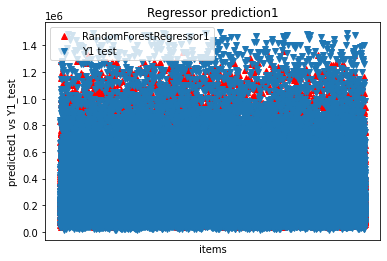

In [41]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

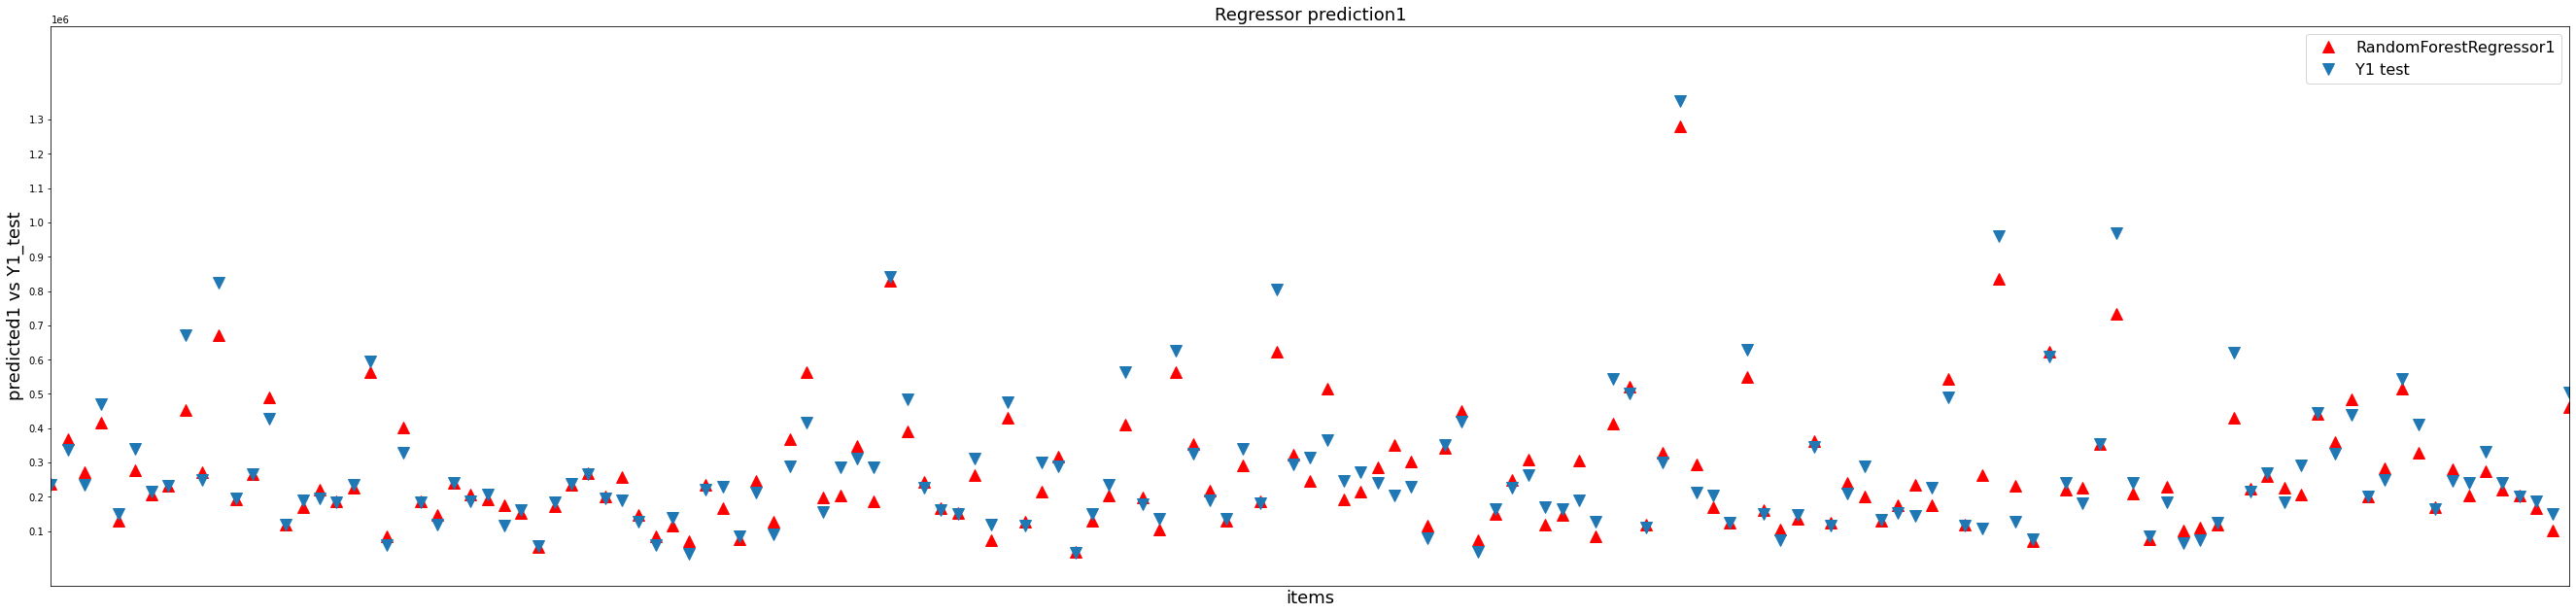

In [42]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [43]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [44]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

69683.90653868603

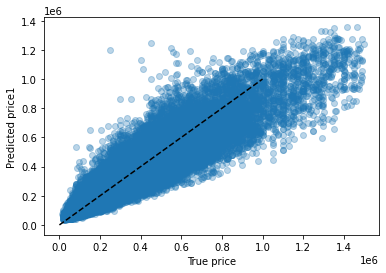

In [45]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [46]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

69364.84320961128

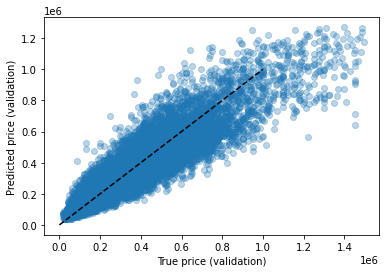

In [47]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()